In [0]:
# install packages
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
from google.colab import files
uploaded = files.upload()



Saving winetrain.csv to winetrain.csv


In [3]:
from google.colab import files
uploaded = files.upload()



Saving winetest.csv to winetest.csv


In [0]:
df_full = pd.read_csv('winetrain.csv', encoding='utf8')

In [5]:
df_full.columns

Index(['user_name', 'country', 'review_title', 'review_description',
       'designation', 'points', 'price', 'province', 'region_1', 'region_2',
       'winery', 'variety'],
      dtype='object')

In [0]:
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
df_full = pd.read_csv('winetrain.csv', encoding='utf8')
df_full.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [8]:
# select wines with over 1050 tasting notes (to make an even 30 varities)
variety_counts = pd.DataFrame(df_full['variety'].value_counts())
varieties      = list(variety_counts.index[variety_counts['variety'] > 1000])

# remove blends
varieties.remove('Red Blend')
varieties.remove('White Blend')
varieties.remove('Sparkling Blend')

len(varieties)

20

In [0]:
df = df_full[df_full['variety'].isin(varieties)]

In [10]:
df.variety.value_counts()

Pinot Noir                  10587
Chardonnay                   9403
Cabernet Sauvignon           7552
Bordeaux-style Red Blend     5497
Riesling                     4148
Sauvignon Blanc              4011
Syrah                        3316
Rosé                         2831
Merlot                       2471
Nebbiolo                     2242
Zinfandel                    2209
Sangiovese                   2165
Malbec                       2119
Portuguese Red               1969
Tempranillo                  1448
Rhône-style Red Blend        1182
Pinot Gris                   1148
Champagne Blend              1133
Cabernet Franc               1095
Grüner Veltliner             1055
Name: variety, dtype: int64

In [11]:
# map classes to integers
df['variety_code'] = pd.Categorical(df.variety).codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df[['variety','variety_code']]

,variety,variety_code
0,Chardonnay,4
2,Nebbiolo,8
4,Malbec,6
5,Cabernet Sauvignon,2
7,Zinfandel,19
...,...,...
82651,Chardonnay,4
82652,Tempranillo,18
82653,Cabernet Sauvignon,2
82655,Bordeaux-style Red Blend,0


In [0]:
# set classes
x = df.review_description.values
y = df.variety_code.values

In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=522)

In [15]:
# majority class prediction
np.mean(y_test == 6)

0.03262558259968928

In [16]:
# data preprocess
tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

(54064, 21747)

In [17]:
# fit model
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.7568987201302064


In [18]:
# grid search on C
def fit_svc(C=1):
    clf             = LinearSVC(C=C).fit(x_train_vec, y_train)
    predicted       = clf.predict(x_test_vec)
    predicted_score = clf.decision_function(x_test_vec)
    return metrics.accuracy_score(y_test, predicted)

for C in [0.1, 0.5, 1, 2, 4, 8]:
    print(fit_svc(C=C))


0.7476511060146482
0.759044166605016
0.7568987201302064
0.7472812014500259
0.7339646371236221
0.7210919582747651


In [19]:
import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

Using TensorFlow backend.


In [20]:
# data preprocess
x = df.review_description.values
y = df.variety_code.values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

136


In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

1. Simple Model

In [0]:
model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                    output_dim=256))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))

model1.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model1.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [24]:
history1 = model1.fit(x_train, y_train,
            batch_size=512,
            epochs=22,
            validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 54064 samples, validate on 13517 samples
Epoch 1/22
54064/54064 [==============================] - 14s 266us/step - loss: 2.5122 - acc: 0.2883 - val_loss: 1.7335 - val_acc: 0.4903
Epoch 2/22
54064/54064 [==============================] - 14s 258us/step - loss: 1.3865 - acc: 0.5797 - val_loss: 1.1334 - val_acc: 0.6535
Epoch 3/22
54064/54064 [==============================] - 14s 257us/step - loss: 0.9919 - acc: 0.6996 - val_loss: 0.9372 - val_acc: 0.7139
Epoch 4/22
54064/54064 [==============================] - 14s 257us/step - loss: 0.8117 - acc: 0.7552 - val_loss: 0.8481 - val_acc: 0.7391
Epoch 5/22
54064/54064 [==============================] - 14s 259us/step - loss: 0.6957 - acc: 0.7889 - val_loss: 0.8065 - val_acc: 0.7528
Epoch 6/22
54064/54064 [==============================] - 14s 258us/step - loss: 0.6169 - acc: 0.8112 - val_loss: 0.7887 - val_acc: 0.7518
Epoch 7/22
54064/54064 [==============================] - 14s 256us/step - loss: 0.5578 - acc: 0.8294 - val_loss: 0.

In [25]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

13517/13517 [==============================] - 1s 58us/step
accuracy 0.7435821294784546


In [26]:
print('train accuracy', model1.evaluate(x_train, y_train)[1])

54064/54064 [==============================] - 3s 57us/step
train accuracy 0.9622484445571899


2. LSTM 

In [0]:

model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))
model2.add(LSTM(128))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [34]:
history2 = model2.fit(x_train, y_train,
            batch_size=512,
            epochs=16,
            validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 54064 samples, validate on 13517 samples
Epoch 1/16
54064/54064 [==============================] - 176s 3ms/step - loss: 2.4745 - acc: 0.2414 - val_loss: 1.8051 - val_acc: 0.4139
Epoch 2/16
54064/54064 [==============================] - 175s 3ms/step - loss: 1.3935 - acc: 0.5531 - val_loss: 1.0629 - val_acc: 0.6712
Epoch 3/16
54064/54064 [==============================] - 175s 3ms/step - loss: 0.9323 - acc: 0.7103 - val_loss: 0.9218 - val_acc: 0.7158
Epoch 4/16
54064/54064 [==============================] - 175s 3ms/step - loss: 0.7327 - acc: 0.7717 - val_loss: 0.9369 - val_acc: 0.7169
Epoch 5/16
54064/54064 [==============================] - 175s 3ms/step - loss: 0.6033 - acc: 0.8103 - val_loss: 0.9687 - val_acc: 0.7119
Epoch 6/16
54064/54064 [==============================] - 175s 3ms/step - loss: 0.5116 - acc: 0.8403 - val_loss: 1.0210 - val_acc: 0.7167
Epoch 7/16
54064/54064 [==============================] - 175s 3ms/step - loss: 0.4302 - acc: 0.8661 - val_loss: 1.1298 - 

3. Bidirectional LSTM

In [0]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_features,
                     output_dim=128))
model3.add(Bidirectional(LSTM(128)))
model3.add(Dropout(0.5))
model3.add(Dense(100, activation="softmax"))

model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [37]:
history3 = model3.fit(x_train, y_train,
            batch_size=512,
            epochs=20,
            validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 54064 samples, validate on 13517 samples
Epoch 1/20
54064/54064 [==============================] - 331s 6ms/step - loss: 2.4781 - acc: 0.2418 - val_loss: 1.7115 - val_acc: 0.4501
Epoch 2/20
54064/54064 [==============================] - 330s 6ms/step - loss: 1.3296 - acc: 0.5721 - val_loss: 1.0292 - val_acc: 0.6643
Epoch 3/20
54064/54064 [==============================] - 330s 6ms/step - loss: 0.8908 - acc: 0.7215 - val_loss: 0.8841 - val_acc: 0.7280
Epoch 4/20
54064/54064 [==============================] - 329s 6ms/step - loss: 0.6894 - acc: 0.7856 - val_loss: 0.9216 - val_acc: 0.7228
Epoch 5/20
54064/54064 [==============================] - 330s 6ms/step - loss: 0.5597 - acc: 0.8244 - val_loss: 0.9662 - val_acc: 0.7225
Epoch 6/20
54064/54064 [==============================] - 331s 6ms/step - loss: 0.4582 - acc: 0.8568 - val_loss: 1.0593 - val_acc: 0.7209
Epoch 7/20
54064/54064 [==============================] - 333s 6ms/step - loss: 0.3902 - acc: 0.8775 - val_loss: 1.0919 - 

In [38]:
print('accuracy', model3.evaluate(x_test, y_test)[1])

13517/13517 [==============================] - 25s 2ms/step
accuracy 0.7004512548446655


Plots and Compare

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
# plot accuracy rates 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred1 = model1.predict_classes(x_test)
# print(classification_report(y_test, y_pred4))

cm = confusion_matrix(y_test, y_pred1) # only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()
accuracies

array([0.80017762, 0.37004405, 0.70282709, 0.67391304, 0.87393617,
       0.72677596, 0.5547619 , 0.47514911, 0.79054054, 0.57383966,
       0.81360805, 0.71717172, 0.66804979, 0.84280532, 0.81801802,
       0.80331754, 0.78200253, 0.61527378, 0.4862069 , 0.6494382 ])

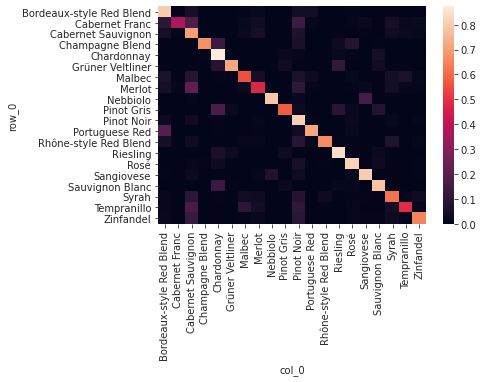

In [42]:
v_lookup = df[['variety_code', 'variety']].drop_duplicates().set_index('variety_code').to_dict()
v_lookup = v_lookup['variety']

y_test_name = np.array([v_lookup[y_code] for y_code in y_test])
y_pred_name = np.array([v_lookup[y_code] for y_code in y_pred1])

to_plot = pd.crosstab(y_test_name, y_pred_name, normalize='index')
sns.heatmap(to_plot)
plt.show()

In [0]:
v_labels = sorted(v_lookup.items(), key=lambda x: x[0])
v_labels = [vv[1] for vv in v_labels]

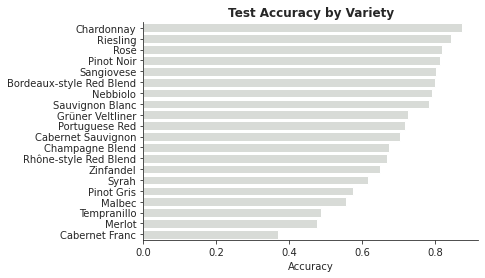

In [44]:
# plot accuracy by wine another way
acc_order = np.argsort(-accuracies) # get index to sort by

sns.barplot(y=np.array(v_labels)[acc_order], x=accuracies[acc_order], color='#d8dcd6')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [45]:
for x in (np.array(v_labels)[acc_order]):
    print(x)

Chardonnay
Riesling
Rosé
Pinot Noir
Sangiovese
Bordeaux-style Red Blend
Nebbiolo
Sauvignon Blanc
Grüner Veltliner
Portuguese Red
Cabernet Sauvignon
Champagne Blend
Rhône-style Red Blend
Zinfandel
Syrah
Pinot Gris
Malbec
Tempranillo
Merlot
Cabernet Franc


In [46]:
for x in (accuracies[acc_order]):
    print(x)

0.8739361702127659
0.8428053204353083
0.818018018018018
0.8136080498322952
0.8033175355450237
0.8001776198934281
0.7905405405405406
0.7820025348542459
0.726775956284153
0.7171717171717171
0.702827087442472
0.6739130434782609
0.6680497925311203
0.6494382022471911
0.6152737752161384
0.5738396624472574
0.5547619047619048
0.4862068965517241
0.47514910536779326
0.3700440528634361


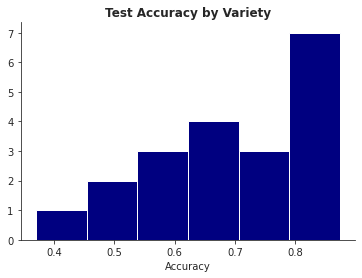

In [47]:
# plot as histogram
plt.hist(accuracies, bins=6, color='navy')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [48]:
v_lookup

{0: 'Bordeaux-style Red Blend',
 1: 'Cabernet Franc',
 2: 'Cabernet Sauvignon',
 3: 'Champagne Blend',
 4: 'Chardonnay',
 5: 'Grüner Veltliner',
 6: 'Malbec',
 7: 'Merlot',
 8: 'Nebbiolo',
 9: 'Pinot Gris',
 10: 'Pinot Noir',
 11: 'Portuguese Red',
 12: 'Rhône-style Red Blend',
 13: 'Riesling',
 14: 'Rosé',
 15: 'Sangiovese',
 16: 'Sauvignon Blanc',
 17: 'Syrah',
 18: 'Tempranillo',
 19: 'Zinfandel'}

In [0]:
import re
import gensim
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
df = pd.read_csv('winetrain.csv', encoding='utf-8')

In [51]:
notes = list(df.review_description) 
len(notes)

82657

In [0]:
# make lowercase and remove punctuation
cleantext = [n.lower() for n in notes]
cleantext = [re.sub('[^a-zA-Z0-9_]+', ' ', n) for n in cleantext]

In [0]:
# tokenize
documents = [n.split() for n in cleantext]

Create Word Embeddings

In [0]:
# define model 
model = gensim.models.Word2Vec(documents, 
                               size=128, 
                               window=5, 
                               min_count=1, 
                               workers=4)

In [55]:
# train model
model.train(documents, total_examples=len(documents), epochs=32)

(78646907, 110320064)

Analysis and vector Math

In [56]:
model.wv.most_similar('oak')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wood', 0.5835341811180115),
 ('oaky', 0.5726167559623718),
 ('barrel', 0.5174472332000732),
 ('marshmallows', 0.45604655146598816),
 ('baguette', 0.45207321643829346),
 ('popcorny', 0.4177224636077881),
 ('dibon', 0.4124108552932739),
 ('hickory', 0.41173914074897766),
 ('grapenuts', 0.40285056829452515),
 ('woodsap', 0.39727696776390076)]

In [57]:
# vector analogy
model.most_similar(positive=['rich', 'sweet'], negative=['pinot'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ripe', 0.6221154928207397),
 ('luscious', 0.5411288142204285),
 ('lush', 0.5361497402191162),
 ('generous', 0.48500725626945496),
 ('bold', 0.47293415665626526),
 ('superripe', 0.469463050365448),
 ('plump', 0.44619303941726685),
 ('plush', 0.4392871856689453),
 ('intense', 0.4342791736125946),
 ('juicy', 0.42800164222717285)]

In [58]:
# vector math
model.most_similar(positive=['chardonnay'], negative=['oak', 'oaky'], topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('whites', 0.464589923620224),
 ('calderara', 0.42713308334350586),
 ('abtsberg', 0.4104187488555908),
 ('adige', 0.4085253179073334),
 ('gers', 0.39661458134651184)]

In [59]:
model.wv.most_similar(positive=['chardonnay', 'red'], negative=['oak'], topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ros', 0.4153553247451782),
 ('white', 0.4055178165435791),
 ('yellow', 0.3761511445045471),
 ('wine', 0.36076998710632324),
 ('chard', 0.35441407561302185),
 ('sparkling', 0.3515552878379822),
 ('moscofilero', 0.34991616010665894),
 ('riesling', 0.34787237644195557),
 ('pink', 0.34573984146118164),
 ('roditis', 0.3402467966079712)]

In [60]:
model.wv.most_similar(positive=['cranberry'], topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pomegranate', 0.8233945369720459),
 ('strawberry', 0.7033939361572266),
 ('rhubarb', 0.6753091812133789),
 ('raspberry', 0.6376192569732666),
 ('hibiscus', 0.621637225151062),
 ('blueberry', 0.6011967658996582),
 ('cranberries', 0.5800467729568481),
 ('boysenberry', 0.5748813152313232),
 ('cherry', 0.5741903781890869),
 ('clove', 0.5542714595794678)]

In [61]:
model.wv.most_similar(positive=['sweet'], topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sweetened', 0.4889257550239563),
 ('confected', 0.47494351863861084),
 ('semisweet', 0.47448819875717163),
 ('candied', 0.448775053024292),
 ('luscious', 0.4316774606704712)]

In [62]:
# save vectors
X = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
# create dataframe
df_vectors = pd.DataFrame(X)
df_vectors['word'] = list(model.wv.vocab.keys())

In [0]:
# save dataframe
df_vectors.to_csv('wine_wv.csv')

In [0]:
pd.DataFrame(X).to_csv('wine_wv.tsv', header=None, sep='\t', index=False)
pd.DataFrame({"word" : list(model.wv.vocab.keys())}).to_csv('wine_labels.tsv', index=False, header=False)

Basic TSNE plot

In [0]:
# fit to tSNE (sklearn version)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [68]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=7f91eae5e102d0346b186b03ab6087fdc08012595bac539d141c196ef2d88867
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [0]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, n_jobs=4)
Y = tsne.fit_transform(X)

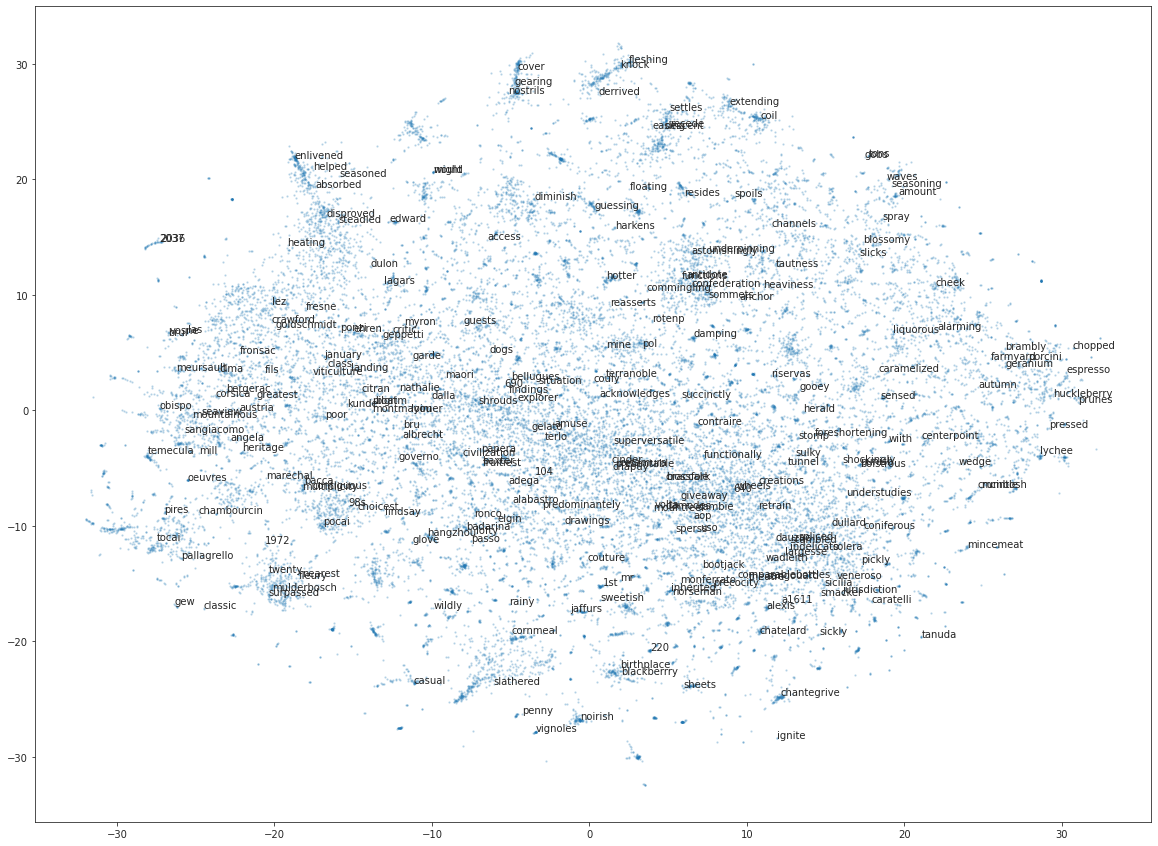

In [70]:
# plot tsne
plt.figure(figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], s=2, alpha=0.2)

for i, txt in enumerate(df_vectors.word):
    if not i % 101:
        plt.annotate(txt, (Y[i,0], Y[i,1]))

plt.show()

Interactive Plot with Bokeh

In [0]:
from bokeh.plotting import figure, show, ColumnDataSource, save
from bokeh.io import output_notebook

output_notebook()

In [0]:
source = ColumnDataSource(data=dict(
    x = Y[:,0],
    y = Y[:,1],
    word = list(df_vectors.word),
))

In [81]:
# set source
source = ColumnDataSource(data=dict(
    x = Y[:,0],
    y = Y[:,1],
    word = list(df_vectors.word),
))


# add hover
TOOLTIPS = [
    ("word", "@word")
]


# set figure
p = figure(plot_width=800, plot_height=600, tooltips=TOOLTIPS, title = 'Wine Word Embeddings (tSNE)')

# add a circle renderer with a size, color, and alpha
p.circle(x = 'x', 
         y = 'y', 
         source = source,
         size = 2, 
         color = "navy", 
         alpha = 0.25)

# show the results
show(p)
